In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets           import load_boston
from sklearn.linear_model       import LinearRegression
from sklearn.ensemble           import RandomForestRegressor
from sklearn.model_selection    import train_test_split
from sklearn.metrics            import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition      import PCA
from sklearn.preprocessing      import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Feature Importance

***Note:*** The underlying functions I wrote to support this notebook are not public as requested by my professor. I would be happy to share or discuss in a private setting.

At the core of data science is not only model predictions, but also the explanatory power of models. In a business setting, it is often not enough to produce correct answers. One must be able to interpret model parameters to potentially help guide business decisions. Feature importance is one such tool that can provide insights on how the predictor features relate to the target. Importances have the additional benefit of identifying unnecessary or unhelpful features which can be dropped to save model training time and compututational resources.

The default feature importances method in sciki-learn's [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_) algorithms is Gini importance which "can be misleading for high cardinality features."

The purpose of this article is to explore other options for feature importance:
 - Feature Based
     - Spearmans' Rho
     - Principal Component Analysis
 - Model Based
     - Drop Column Importance
     - Permutation Column Importance
     
The example dataset will be sklearn's boston dataset:
 - Target: median value of owner-occupied homes ($1000s)
 - Predictors: 13 numeric and categorical variables

In [247]:
%run featimp

In [3]:
boston = load_boston()
X, y = boston.data, boston.target
features = boston.feature_names

In [22]:
x_df = pd.DataFrame(X,columns=features)
y_df = pd.DataFrame(y,columns=['price'])
df = pd.concat([x_df,y_df],axis=1)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Feature Based Strategy

Importances from this strategy are calculated without models and solely use the data.

### Spearman's Rho

- *What*: 
  - Correlation coefficient calculated on continuous variables
- *How*: 
  - Replace data with their ranks then compute the Pearson correlation coefficient
- *Importances*: 
  - Features with the highest coefficient (positive or negative) are more important for predicting the target
- *Benefits*: 
  - Using ranks rather than the actual data makes Spearman's rho less sensitive to outliers and departures from a normal distribution
- *Issues*: 
  - Cannot be used on categorical values with more than two classes
  - Simple as it only considers linear correlation

To calculate Spearman's rho:
 - drop categorical variables with more than 2 classes
 - specify 'spearman' in pandas correlation method
 - extract target column and sort by absolute values

In [171]:
# Spearman's rho for price sorted by absolute value
corr = df.corr(method='spearman')
corr_sort = corr[['price']].apply(np.abs).sort_values(by=['price'], ascending=False).iloc[1:,:]
corr_sort

,price
LSTAT,0.852914
RM,0.633576
INDUS,0.578255
NOX,0.562609
TAX,0.562411
CRIM,0.558891
PTRATIO,0.555905
AGE,0.547562
DIS,0.445857
ZN,0.438179


Because correlation can be negative or positive, we sort by the absolute value and see that LSTAT (lower status of the population) and RM (average number of rooms per dwelling) are most correlated with price.

# Principal Component Analysis (PCA)

- *What*: 
   - Recomputed X array in which each feature accounts for more variance in data than the following feature
   - All features are uncorrelated
   - Has the same dimensions as input X
- *How*: 
  - Uses covariance matrix and related eigenvectors and eigenvalues to create linear combinations of input features
- *Importances*: 
  - Features ranked by order (first feature is most important, second feature is second most important etc)
- *Benefits*: 
  - Dimensionality reduction by choosing a threshold (i.e. 95%) and only using k features in the model
- *Issues*: 
  - Not interpretable as features are "principal components" rather than tangible data points
  - Although choosing k based on a high threshold will allow the model to see a large majority of input data, it will not see full variation of feature data if dimension is reduced.

To calculate PCA features:
 - Standardize data (required so that features with large ranges will not dominate those will small ranges)
 - Calculate eigenvectors and eigenvalues from covariance matrix
 - Construct principal components as linear combinations of input variables such that: new variables are uncorrelated and most information in first component, second most information in second component, and so on

In [28]:
# Standardize data
X_scaled = StandardScaler().fit_transform(X)

In [232]:
# Create n-dimension PCA
n = X_scaled.shape[1]
pca = PCA(n)
X_pca = pca.fit_transform(X_scaled)

First observation in X after applying PCA (its values are unbound to anything in the real world):

In [44]:
# First observation
X_pca[0].round(3)

array([-2.098,  0.773,  0.343, -0.892,  0.423, -0.315,  0.319,  0.296,
       -0.425,  0.64 , -0.033,  0.019,  0.366])



For the 13 dimensional principal components, the first feature explains 47% of the variation in X and the second feature explains 11%. Together, the first and second features cumulatively explain 58%. When all features have been accounted for, the principal components will account for 100% of the variation in X.

In [50]:
# Explained variance per PC
pca_evr = pca.explained_variance_ratio_
print('Explained Variance: \n', pca_evr.round(3), '\n')
print('Cumulative Explained Variance: \n', np.cumsum(pca_evr))

Explained Variance: 
 [0.471 0.11  0.096 0.066 0.064 0.051 0.041 0.03  0.021 0.017 0.014 0.013
 0.005] 

Cumulative Explained Variance: 
 [0.47129606 0.581548   0.67713389 0.74310121 0.80731782 0.8578876
 0.89906884 0.92953786 0.9508412  0.96778257 0.98209137 0.99511467
 1.        ]


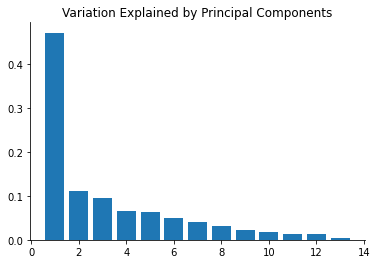

In [240]:
fig, ax = plt.subplots(figsize=(6,4))
plt.bar(range(1,n+1),pca_evr)
plt.title('Variation Explained by Principal Components')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Model Based Strategy

Importances calculated by comparing metrics as various changes are made to the input data.

### Permutation Importance

- *How*: 
  - Features permuted iteratively
  - Metric recalculated and compared to baseline
  - Both the above use the test dataset
- *Importances*: 
  - Features with the greatest difference between the baseline and recalculated metric are considered most important
- *Benefits*: 
  - Can be computed without retraining model which can be computationally expensive
- *Issues*: 
  - Correlated features may appear more important than they actually are

To calculate:
 - Train a model and record baseline metric
 - Using test data, for each column, permute values and recalculate metric using pretrained model
 - Compute difference between the recalculated metric and the baseline

In [131]:
# Train initial model
rf = RandomForestRegressor()
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor()

In [181]:
# Permutation Importance using pretrained model
I_permcol = permutation_imp(rf, X_test, y_test, mean_squared_error)
I_permcol['Importances'] = I_permcol['Importances']*-1 # multiply by -1 since negative MSE
I_permcol = I_permcol.sort_values(by=['Importances'],ascending=False)
I_permcol

,Importances
LSTAT,74.333385
RM,41.078421
NOX,4.245393
CRIM,3.636084
DIS,3.483645
PTRATIO,2.224210
B,1.023680
AGE,0.770386
TAX,0.765665
INDUS,0.324470


### Drop Column Importance

- *How*: 
  - Features dropped iteratively
  - Model retrained without dropped column
  - Metric recalculated and compared to baseline
- *Importances*: 
  - Features with the greatest difference between the baseline and recalculated metric are considered most important
- *Benefits*: 
  - Intuitively, dropping a feature is the most accurate way to see a feature's importance to a target
- *Issues*: 
  - Computationally expensive since new model must be trained for each dropped column
  - Similar to permutation importance, inflated importance for correlated features

To calculate:
 - Train a model and record baseline metric
 - Drop column, train new model, and calculate new metric
 - Compute difference between the new metric and the baseline

In [222]:
I_dropcol = dropcol_importances(RandomForestRegressor(), x_df, y_df, mean_squared_error)
I_dropcol['Importances'] = I_dropcol['Importances']*-1 # multiply by -1 since negative MSE
I_dropcol = I_dropcol.sort_values(by=['Importances'],ascending=False)
I_dropcol

,Importances
RM,6.659976
LSTAT,3.918843
NOX,0.781871
TAX,0.598182
CRIM,0.340849
PTRATIO,0.269271
DIS,0.178680
B,0.118829
RAD,0.057006
CHAS,-0.001898


Permutation importance and drop column importance give similar orders of feature importance but different values.

### Comparing Importance Strategies

Here are the most important features as ranked by the different strategies. Ordinary Least Squares is added to show another simple option.

In [189]:
# OLS: Use absolute value of regression coefficients as importances
regr = LinearRegression().fit(X, y)
I_regr = list(zip(features,regr.coef_.round(2)))
I_regr.sort(key=lambda x: abs(x[1]),reverse=True)
I_regr = pd.DataFrame(I_regr,columns=['col','Importances']).set_index('col')
I_regr['Importances'] = abs(I_regr['Importances']) # use absolute value since coeffiencts can be positive or negative
I_regr.index.name = None

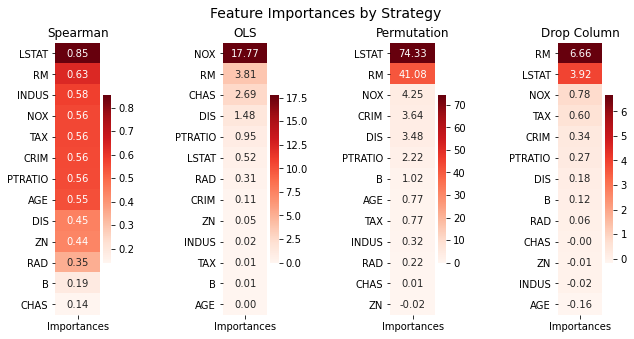

In [226]:
fig, axs = plt.subplots(ncols=4, figsize=(10,5))
fig.suptitle('Feature Importances by Strategy', size=14)
plt.subplots_adjust(wspace = 2)
sns.heatmap(corr_sort.rename(columns={"price": "Importances"}), annot=True, cmap='Reds',fmt='.2f', ax=axs[0])
sns.heatmap(I_regr, annot=True, cmap='Reds',fmt='.2f', ax=axs[1])
sns.heatmap(I_permcol, annot=True, cmap='Reds',fmt='.2f', ax=axs[2])
sns.heatmap(I_dropcol, annot=True, cmap='Reds',fmt='.2f', ax=axs[3])
axs[0].set_title('Spearman')
axs[1].set_title('OLS')
axs[2].set_title('Permutation')
axs[3].set_title('Drop Column')
plt.tight_layout(pad=50)
plt.show()

Although the units of these importances are different (Spearman correlation coefficients, OLS parameter coefficients, and permutation/drop column MSE decrease), the order of features and relative importance can be reviewed. There is a fair bit of variability between the features identified by each strategy; however permutation and drop column do have similar orders.

To further compare these strategies, we do a 5 fold cross validation starting with only the most important feature, train a model, and record the score. On the next iteration, the next most important feature is also included in the model and so on until all features have been included. The results of the change in metric are plotted below.

In [228]:
# Get column names ordered by importance
perm_cols = I_permcol.index
drop_cols = I_dropcol.index
spearman_cols = corr_sort.index
regr_cols = [x[0] for x in I_regr]
spearman_cols

Index(['LSTAT', 'RM', 'INDUS', 'NOX', 'TAX', 'CRIM', 'PTRATIO', 'AGE', 'DIS',
       'ZN', 'RAD', 'B', 'CHAS'],
      dtype='object')

In [229]:
# Compute 5-fold CV metrics
spearman_metrics = k_impfts_colname(RandomForestRegressor(),spearman_cols, x_df, y_df, 'neg_mean_squared_error')
pca_metrics = k_impfts_colidx(RandomForestRegressor(),X_pca,y,'neg_mean_squared_error')
perm_metrics = k_impfts_colname(RandomForestRegressor(),perm_cols, x_df, y_df, 'neg_mean_squared_error')
drop_metrics = k_impfts_colname(RandomForestRegressor(),drop_cols, x_df, y_df, 'neg_mean_squared_error')
regr_metrics = k_impfts_colname(LinearRegression(),regr_cols, x_df, y_df, 'neg_mean_squared_error')
result={'spearman':spearman_metrics, 'PCA':pca_metrics, 
        'permutation':perm_metrics,'drop':drop_metrics,'regr':regr_metrics}

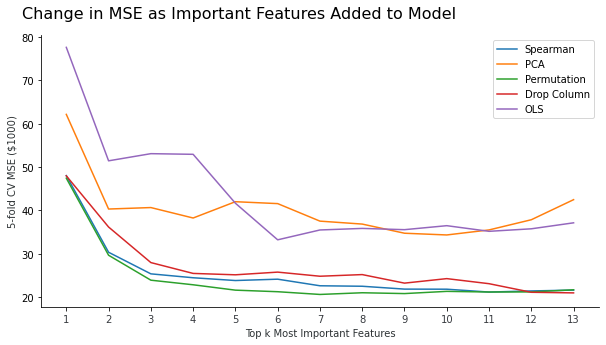

In [224]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Change in MSE as Important Features Added to Model', fontsize=16, x=.4, y=.96)

plt.plot(result['spearman'],label='Spearman')
plt.plot(result['PCA'], label='PCA')
plt.plot(result['permutation'],label='Permutation')
plt.plot(result['drop'], label='Drop Column')
plt.plot(result['regr'], label='OLS')
ax.set_ylabel('5-fold CV MSE ($1000)', color='#2D3234')
ax.set_xlabel('Top k Most Important Features', color='#2D3234')
plt.xticks(range(13),color='#2D3234')
ax.set_xticklabels(range(1,14),color='#383B40', fontsize=10)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

For this dataset, Spearman, Permutation, and Drop Column perform similarly plateauing around 9 features. Feature importance is useful in this small dataset to provide insights for model interpretation. We may choose to drop features with negative importances, but it is not too computationally expensive to run a model with all features. 

In a large dataset however, feature importance may play a more critical role in feature selection. We wouldn't want to run a model on unnecessary or unimportant features if model training was computationally expensive. Although PCA did not perform well in this analysis, its dimension reduction while still capturing data variability could be extremely handy for saving training time and computational resources.

### Automatic Feature Selection

Using the importances, features can be dropped iteratively until the metric does not to improve. In the brief example below, the least important column as identified by drop column importance is dropped but the metric is not improved. Thus, the algorithm suggests that the best model includes all features. Again, while this smaller model does not improve by dropping low importance features, a bigger model with more features and observations may show more improvement in terms of metric and computation time.

In [249]:
# Run automatic selection -> dropping ZN does not improve metric
best_cols = auto_ft_selection(x_df,y_df)
print('Best features: ', best_cols)

Baseline:  21.73
New metric: 22.02  Column dropped: ZN
Best features:  ['LSTAT', 'RM', 'DIS', 'NOX', 'PTRATIO', 'B', 'CRIM', 'TAX', 'CHAS', 'INDUS', 'RAD', 'AGE', 'ZN']
